In [ ]:
# This reads in
# 1. FITS header information
# 2. FFT information about the PSF
# ... in order to figure out whether a Fizeau PSF consists of
# well-overlapped Airy PSFs that are stable other than phase diversity

# created 2018 Nov 26 by E.S.

In [2]:
# Import stuff

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from astropy.io import fits
import pandas as pd
from datetime import datetime
%matplotlib inline

In [3]:
stem = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/'+
        '180507_fizeau_altair/05_centered/')

In [4]:
# Read in the metadata file of FITS header information

fits_table = pd.read_csv('fizeau_altair_180507_metadata.csv')

# sort table by frame number (a few are out of order)
fits_table.sort_values(["FRAMENUM"], inplace=True)
fits_table = fits_table.reset_index(drop=True) # reset indices and don't keep the old ones

/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (13,80,81,84,88,92,149) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Read in the PSF FFT information

fft_table = pd.read_csv('fizeau_altair_180507_psf_fft_info_2.csv') # *_2.csv includes stdev information

In [6]:
# apply cutoffs and generate list of frame numbers that pass

In [7]:
# FITs keys cutoffs:

# ["PCCLOSED"]==1
# ["LLOOPON"]==1
# ["RLOOPON"]==1
# ["ACTEXP"]=="145976"
# ["LMIR_FW1"]=="94800"
# ["LMIR_FW2"]=="ND1.0-T10"
# ["LMIRFW25"]=="Lspec2.8-4.0" OR "Open" (may have to keep these filters distinct later)
# ["LMIR_FW3"]=="Open"
# ["LMIR_FW4"]=="Br-Alpha-On"

winnowed_frames_fitsKey = fits_table.index[(fits_table["PCCLOSED"] == 1) & 
                                   (fits_table["LLOOPON"] == 1) &
                                   (fits_table["RLOOPON"] == 1) &
                                   (fits_table["ACTEXP"] == 145976) &
                                   (fits_table["LMIR_FW1"] == "94800") &
                                   (fits_table["LMIR_FW2"] == "ND1.0-T10") &
                                   (np.logical_or(fits_table["LMIRFW25"] == "Lspec2.8-4.0",
                                                  fits_table["LMIRFW25"] == "Open")) &
                                   (fits_table["LMIR_FW3"] == "Open") &
                                   (fits_table["LMIR_FW4"] == "Br-Alpha-On")]



# (may have to keep these filters in FW 2.5 distinct later)

In [7]:
np.shape(winnowed_frames_fitsKey)

(3113,)

In [56]:
# FFT info cutoffs:

# amplitude of high-freq node of FFT amplitude > 20000
# (i.e., close to center of coherence envelope)

fft_ampl_high_freq_lowlimit = 2.4e5
fft_ampl_low_freq_lowlimit = 1.4e6
fft_phase_vec_high_freq_highlimit = 5 # limit of absolute value of either x or y vector

fft_table.rename(columns={'framenum':'FRAMENUM'}, inplace=True) # rename column for merger later
#winnowed_frames_fftInfo = fft_table.index[np.logical_and(fft_table["ampl_med_highFreqPerfect_R"] > fft_phase_high_freq_lowlimit,
#                                                         fft_table["ampl_med_highFreqPerfect_R"] > fft_phase_high_freq_lowlimit)]

winnowed_frames_fftAmplInfo = fft_table.index[np.logical_and(
    fft_table["ampl_med_highFreqPerfect_R"] > fft_ampl_high_freq_lowlimit,
    fft_table["ampl_med_lowFreqPerfect"] > fft_ampl_low_freq_lowlimit)]

winnowed_frames_fftPhaseInfo = fft_table.index[np.logical_and(
    np.abs(fft_table["phase_normVec_highFreqPerfect_R_x"]) < fft_phase_vec_high_freq_highlimit,
    np.abs(fft_table["phase_normVec_highFreqPerfect_R_y"]) < fft_phase_vec_high_freq_highlimit)]

In [57]:
# other cutoffs 

# mark and sum the frames with PC loop closed only one frame (no consecutive ones)
counter = 0

framenums_from_1closed = []

for t in range(1,len(fits_table["PCCLOSED"])-1):
    #print(fits_table["PCCLOSED"][t])
    if fits_table["PCCLOSED"][t] == 1:
        if np.logical_and(fits_table["PCCLOSED"][t-1] == -99999,fits_table["PCCLOSED"][t+1] == -99999):
            framenums_from_1closed = np.append(framenums_from_1closed, fits_table["FRAMENUM"][t])
            counter += 1

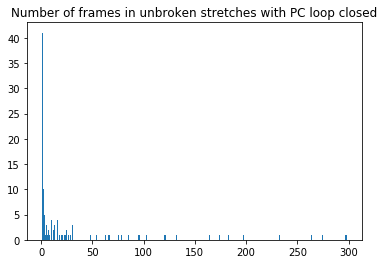

In [47]:
# FYI: find how long the PCCLOSED=1 stretches are

durations = []
counter   = 0

for elem in fits_table["PCCLOSED"]:
    if (elem==1):
        counter += 1
    elif counter > 0:
        durations.append(counter)
        counter = 0

if counter > 0:
    durations.append(counter)
    
plt.hist(durations, bins=300)
#plt.xlim([0,10])
plt.title('Number of frames in unbroken stretches with PC loop closed')
#plt.savefig('unbroken_stretches.png')
plt.show()

In [46]:
# find the overlapping frame numbers between the list of frames 
# winnowed by FITS key values, and FFT high-freq power

In [58]:
# rows containing frames of interest: fits_table.loc[winnowed_frames_fitsKey]
# actual frame numbers corresponding to those rows: fits_table.loc[winnowed_frames_fitsKey]["FRAMENUM"]

# extract frame info for shared frames
frameInfo_from_fitsKey = fits_table.loc[winnowed_frames_fitsKey]
frameInfo_from_fftAmplInfo = fft_table.loc[winnowed_frames_fftAmplInfo]
frameInfo_from_fftPhaseInfo = fft_table.loc[winnowed_frames_fftPhaseInfo]

# extract the frame numbers alone (just FYI for now)
framenums_from_fitsKey = fits_table.loc[winnowed_frames_fitsKey]["FRAMENUM"].reset_index()
framenums_from_fftAmplInfo = fft_table.loc[winnowed_frames_fftAmplInfo]["FRAMENUM"].reset_index()
framenums_from_fftPhaseInfo = fft_table.loc[winnowed_frames_fftPhaseInfo]["FRAMENUM"].reset_index()

In [59]:
# find the shared frame numbers and merge the tables based on those

# merge the frames based on FFT info first
frames_fft_shared = pd.merge(frameInfo_from_fftAmplInfo, frameInfo_from_fftPhaseInfo[["FRAMENUM"]], how="inner", on=["FRAMENUM"])

# now merge the frames based on FFT info with the FITS key ones
frames_shared = pd.merge(frameInfo_from_fitsKey, frames_fft_shared, how="inner", on=["FRAMENUM"])

In [66]:
framenums_from_1closed_df = pd.DataFrame(framenums_from_1closed, columns=["FRAMENUM"])

In [68]:
frames_shared_test = pd.merge(frames_shared, framenums_from_1closed_df, how="outer", on=["FRAMENUM"])

In [86]:
print(frames_shared["FRAMENUM"].where(frames_shared["FRAMENUM"].isin(framenums_from_1closed)).dropna())

1361    10501.0
1464    10851.0
Name: FRAMENUM, dtype: float64


In [87]:
framenums_from_1closed

array([ 4351.,  4391.,  5055.,  5186.,  5188.,  5239.,  5241.,  5245.,
        5261.,  5287.,  5289.,  5338.,  5388.,  5393.,  5435.,  5449.,
        5451.,  5472.,  5478.,  6038.,  6042.,  6059.,  6444.,  6525.,
        6826.,  6829.,  7123.,  8708.,  8830.,  9546.,  9584.,  9746.,
       10158., 10178., 10186., 10501., 10851., 11042., 11049., 11120.,
       11184.])

In [88]:
frames_shared["FRAMENUM"]

0        4543
1        4544
2        4545
3        4546
4        4547
5        4549
6        4550
7        4556
8        4564
9        4621
10       4745
11       4764
12       4766
13       4767
14       4774
15       4776
16       4777
17       4780
18       4783
19       4784
20       4785
21       4786
22       4787
23       4789
24       5107
25       5933
26       5934
27       5935
28       5936
29       5937
        ...  
1572    11286
1573    11287
1574    11289
1575    11290
1576    11292
1577    11293
1578    11294
1579    11296
1580    11300
1581    11301
1582    11302
1583    11303
1584    11304
1585    11306
1586    11307
1587    11308
1588    11309
1589    11310
1590    11311
1591    11312
1592    11313
1593    11314
1594    11315
1595    11316
1596    11317
1597    11318
1598    11319
1599    11332
1600    11333
1601    11335
Name: FRAMENUM, dtype: int64

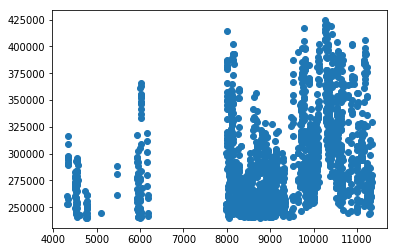

In [11]:
# TESTING ONLY

plt.scatter(frames_shared.loc[:]["FRAMENUM"],frames_shared.loc[:]["ampl_med_highFreqPerfect_R"])
#plt.xlim([5000,6000])
plt.show()

In [62]:
frames_shared.keys() #["ampl_med_lowFreqPerfect"]

Index([u'Unnamed: 0', u'ACTEXP', u'AGE_STOP', u'BADROWS', u'BAYXCUR',
       u'BAYXREQ', u'BAYYCUR', u'BAYYREQ', u'BITPIX', u'BSCALE',
       ...
       u'phase_std_lowFreqPerfect_y', u'phase_std_rect_y',
       u'phase_normVec_highFreqPerfect_L_x_y',
       u'phase_normVec_highFreqPerfect_L_y_y',
       u'phase_normVec_highFreqPerfect_R_x_y',
       u'phase_normVec_highFreqPerfect_R_y_y',
       u'phase_normVec_lowFreqPerfect_x_y',
       u'phase_normVec_lowFreqPerfect_y_y', u'phase_normVec_rect_x_y',
       u'phase_normVec_rect_y_y'],
      dtype='object', length=235)

<Figure size 432x288 with 0 Axes>

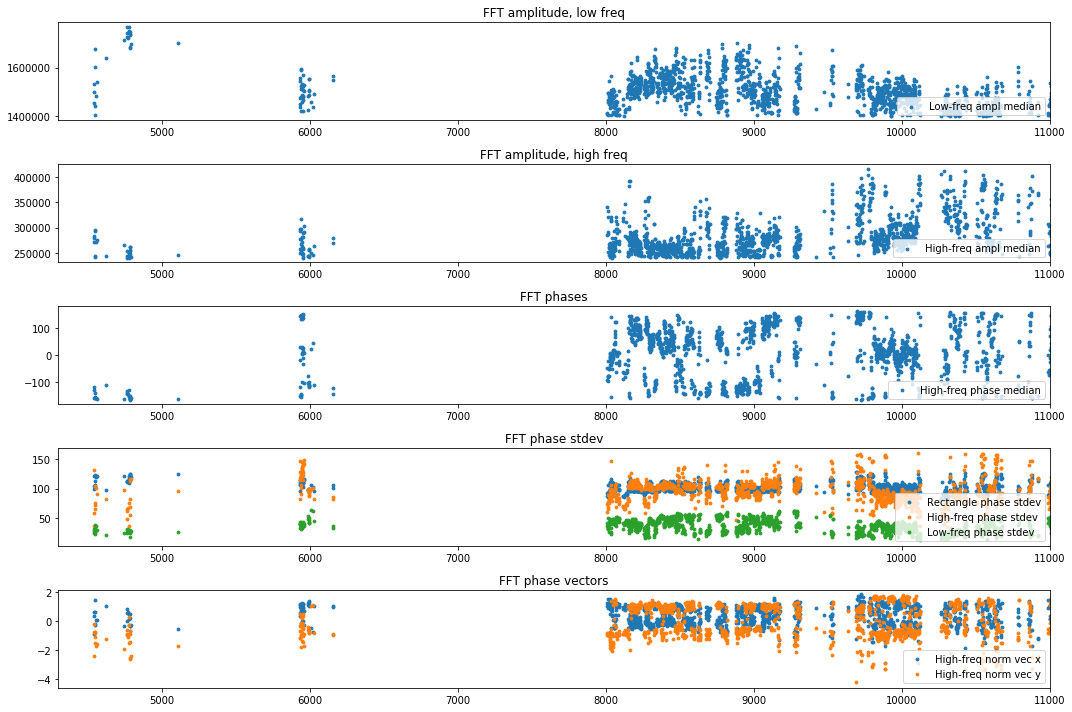

In [73]:
# TESTING ONLY

#xlim_array = [4300,11000] # [4300,11500]
#x_mark = [9694]

mark_size = 8

plt.clf()
fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot(511)
plt.title('FFT amplitude, low freq')
plt.scatter(frames_shared.loc[:]["FRAMENUM"],
            frames_shared.loc[:]["ampl_med_lowFreqPerfect"], 
            s=mark_size,
            label = "Low-freq ampl median")
plt.xlim(xlim_array)
#plt.ylim([0,400000])
plt.legend(loc=4)
#[plt.axvline(x=x_mark_i, linestyle='--', color='red') for x_mark_i in x_mark]

ax2 = plt.subplot(512, sharex=ax1)
plt.title('FFT amplitude, high freq')
plt.scatter(frames_shared.loc[:]["FRAMENUM"],
            frames_shared.loc[:]["ampl_med_highFreqPerfect_R"], 
            s=mark_size,
            label = "High-freq ampl median")
plt.xlim(xlim_array)
#plt.ylim([0,4e5])
plt.legend(loc=4)
#[plt.axvline(x=x_mark_i, linestyle='--', color='red') for x_mark_i in x_mark]

ax3 = plt.subplot(513, sharex=ax1)
plt.title('FFT phases')
plt.scatter(frames_shared.loc[:]["FRAMENUM"],
            frames_shared.loc[:]["phase_med_highFreqPerfect_R"], 
            s=mark_size,
            label = "High-freq phase median")
#plt.scatter(frames_shared.loc[:]["FRAMENUM"],
#            frames_shared.loc[:]["phase_med_lowFreqPerfect"])
plt.xlim(xlim_array)
plt.legend(loc=4)
#[plt.axvline(x=x_mark_i, linestyle='--', color='red') for x_mark_i in x_mark]

ax4 = plt.subplot(514, sharex=ax1)
plt.title('FFT phase stdev')
plt.scatter(frames_shared.loc[:]["FRAMENUM"],
            frames_shared.loc[:]["phase_std_rect"], 
            s=mark_size,
            label = "Rectangle phase stdev")
plt.scatter(frames_shared.loc[:]["FRAMENUM"],
            frames_shared.loc[:]["phase_std_highFreqPerfect_R"], 
            s=mark_size,
            label = "High-freq phase stdev")
plt.scatter(frames_shared.loc[:]["FRAMENUM"],
            frames_shared.loc[:]["phase_std_lowFreqPerfect"], 
            s=mark_size,
            label = "Low-freq phase stdev")
plt.legend(loc=4)
#[plt.axvline(x=x_mark_i, linestyle='--', color='red') for x_mark_i in x_mark]


ax5 = plt.subplot(515, sharex=ax1)
plt.title('FFT phase vectors')
plt.scatter(frames_shared.loc[:]["FRAMENUM"],
            frames_shared.loc[:]["phase_normVec_highFreqPerfect_R_x"], 
            s=mark_size,
            label = "High-freq norm vec x")
plt.scatter(frames_shared.loc[:]["FRAMENUM"],
            frames_shared.loc[:]["phase_normVec_highFreqPerfect_R_y"], 
            s=mark_size,
            label = "High-freq norm vec y")
plt.legend(loc=4)
#[plt.axvline(x=x_mark_i, linestyle='--', color='red') for x_mark_i in x_mark]



'''
plt.scatter(frames_shared.loc[:]["FRAMENUM"],
            np.sqrt(np.add(
                np.power(
                    frames_shared.loc[:]["phase_normVec_highFreqPerfect_R_x"],
                    2
                ),
                np.power(
                    frames_shared.loc[:]["phase_normVec_highFreqPerfect_R_y"],
                    2
                )
            )))
'''
plt.xlim(xlim_array)
#plt.ylim([-2,2])
plt.tight_layout()
plt.savefig("test.png")

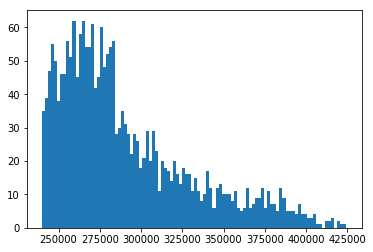

In [12]:
# TESTING ONLY

plt.hist(frames_shared.loc[:]["ampl_med_highFreqPerfect_R"], bins=100)
plt.show()

In [13]:
# TESTING ONLY

N = 5
print(frames_shared.loc[10]["FRAMENUM"])
print(frames_shared.loc[10]["ampl_med_highFreqPerfect_R"])

4342
296601.58522895235


In [74]:
# TESTING ONLY

len(frames_shared)

1602

In [77]:
# loop over all the 'good' frames and copy them to a directory along with a png

for goodFrame in range(0,len(frames_shared)):
    
    # read in frame
    frameNum = frames_shared["FRAMENUM"][goodFrame]
    filename = 'lm_180507_'+str("{:0>6d}".format(frameNum))+'_nPCA164.fits'
    image, header = fits.getdata(stem + filename, 0, header=True)
    
    # write out PNG
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(image, origin="lower")
    fig.suptitle('Frame '+str("{:0>6d}".format(frameNum)))
    fig.savefig(stem + '../06_winnowed/pngs/' + \
                'lm_180507_'+str("{:0>6d}".format(frameNum))+'.png', overwrite=True)
    fig.clf()
    plt.close()
    del(fig)

    # write out FITS frame
    header["PARANG"] = header["LBT_PARA"]
    hdul = fits.PrimaryHDU(image, header=header)
    hdul.writeto(stem + '../06_winnowed/' + filename, overwrite=True)
    
    print('Frame '+str("{:0>6d}".format(frameNum))+' written...')

Frame 004543 written...
Frame 004544 written...
Frame 004545 written...
Frame 004546 written...
Frame 004547 written...
Frame 004549 written...
Frame 004550 written...
Frame 004556 written...
Frame 004564 written...
Frame 004621 written...
Frame 004745 written...
Frame 004764 written...
Frame 004766 written...
Frame 004767 written...
Frame 004774 written...
Frame 004776 written...
Frame 004777 written...
Frame 004780 written...
Frame 004783 written...
Frame 004784 written...
Frame 004785 written...
Frame 004786 written...
Frame 004787 written...
Frame 004789 written...
Frame 005107 written...
Frame 005933 written...
Frame 005934 written...
Frame 005935 written...
Frame 005936 written...
Frame 005937 written...
Frame 005938 written...
Frame 005939 written...
Frame 005940 written...
Frame 005941 written...
Frame 005942 written...
Frame 005943 written...
Frame 005944 written...
Frame 005945 written...
Frame 005946 written...
Frame 005947 written...
Frame 005948 written...
Frame 005950 wri

Frame 008395 written...
Frame 008396 written...
Frame 008397 written...
Frame 008398 written...
Frame 008399 written...
Frame 008400 written...
Frame 008401 written...
Frame 008402 written...
Frame 008403 written...
Frame 008404 written...
Frame 008405 written...
Frame 008406 written...
Frame 008407 written...
Frame 008408 written...
Frame 008409 written...
Frame 008410 written...
Frame 008411 written...
Frame 008412 written...
Frame 008413 written...
Frame 008414 written...
Frame 008415 written...
Frame 008416 written...
Frame 008417 written...
Frame 008419 written...
Frame 008420 written...
Frame 008421 written...
Frame 008422 written...
Frame 008423 written...
Frame 008424 written...
Frame 008425 written...
Frame 008426 written...
Frame 008427 written...
Frame 008428 written...
Frame 008429 written...
Frame 008430 written...
Frame 008431 written...
Frame 008433 written...
Frame 008434 written...
Frame 008435 written...
Frame 008436 written...
Frame 008437 written...
Frame 008438 wri

Frame 008956 written...
Frame 008957 written...
Frame 008958 written...
Frame 008959 written...
Frame 008960 written...
Frame 008961 written...
Frame 008962 written...
Frame 008963 written...
Frame 008964 written...
Frame 008965 written...
Frame 008966 written...
Frame 008968 written...
Frame 008969 written...
Frame 008970 written...
Frame 008971 written...
Frame 008972 written...
Frame 008973 written...
Frame 008974 written...
Frame 008975 written...
Frame 008976 written...
Frame 008977 written...
Frame 008978 written...
Frame 008979 written...
Frame 008980 written...
Frame 008981 written...
Frame 008982 written...
Frame 008983 written...
Frame 008984 written...
Frame 008985 written...
Frame 008986 written...
Frame 008987 written...
Frame 008988 written...
Frame 008989 written...
Frame 008990 written...
Frame 008991 written...
Frame 008992 written...
Frame 008993 written...
Frame 008994 written...
Frame 008995 written...
Frame 008996 written...
Frame 008997 written...
Frame 008998 wri

Frame 009851 written...
Frame 009852 written...
Frame 009854 written...
Frame 009856 written...
Frame 009857 written...
Frame 009858 written...
Frame 009859 written...
Frame 009860 written...
Frame 009861 written...
Frame 009862 written...
Frame 009863 written...
Frame 009864 written...
Frame 009865 written...
Frame 009866 written...
Frame 009867 written...
Frame 009868 written...
Frame 009869 written...
Frame 009870 written...
Frame 009871 written...
Frame 009872 written...
Frame 009873 written...
Frame 009874 written...
Frame 009875 written...
Frame 009876 written...
Frame 009877 written...
Frame 009878 written...
Frame 009879 written...
Frame 009880 written...
Frame 009881 written...
Frame 009883 written...
Frame 009884 written...
Frame 009885 written...
Frame 009886 written...
Frame 009887 written...
Frame 009888 written...
Frame 009889 written...
Frame 009890 written...
Frame 009894 written...
Frame 009895 written...
Frame 009896 written...
Frame 009897 written...
Frame 009898 wri

Frame 010535 written...
Frame 010536 written...
Frame 010538 written...
Frame 010539 written...
Frame 010540 written...
Frame 010542 written...
Frame 010543 written...
Frame 010544 written...
Frame 010545 written...
Frame 010546 written...
Frame 010548 written...
Frame 010549 written...
Frame 010550 written...
Frame 010555 written...
Frame 010556 written...
Frame 010557 written...
Frame 010559 written...
Frame 010561 written...
Frame 010564 written...
Frame 010565 written...
Frame 010566 written...
Frame 010567 written...
Frame 010568 written...
Frame 010569 written...
Frame 010570 written...
Frame 010571 written...
Frame 010572 written...
Frame 010573 written...
Frame 010574 written...
Frame 010575 written...
Frame 010576 written...
Frame 010577 written...
Frame 010578 written...
Frame 010579 written...
Frame 010581 written...
Frame 010582 written...
Frame 010584 written...
Frame 010587 written...
Frame 010588 written...
Frame 010589 written...
Frame 010590 written...
Frame 010591 wri